Updates: Pyspark is now installed on my local computer. It turned out to be difficult to load the data from my S3 bucket because dataframes in Pyspark appear to load lazily (if I create a temporary directory to store the files "downloaded" from the S3 bucket, then try to access the dataframe outside of the "with" loop in which the temporary directory exists, it throws a "File Not Found" error.)

So for now, I'm creating a proof-of-concept model with the 1 million record sample I generated using Pandas earlier which I saved to a file in the data folder.

Import Pyspark, start a Spark Session, load the transactions data.

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.ml.recommendation import ALS
from pyspark.mllib.evaluation import RankingMetrics

In [2]:
spark = SparkSession.builder.appName('H&M Recommendation System').getOrCreate()

23/04/03 14:05:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
%%time
transactions = spark.read.csv('data/transactions_sample.csv', header=True)

CPU times: user 2.47 ms, sys: 2.4 ms, total: 4.87 ms
Wall time: 4.57 s


In [4]:
transactions.show(5)

+--------+----------+--------------------+----------+--------------------+----------------+
|     _c0|     t_dat|         customer_id|article_id|               price|sales_channel_id|
+--------+----------+--------------------+----------+--------------------+----------------+
| 6819188|2019-02-28|cf4254f236a7d3f4d...| 639192002| 0.06777966101694917|               1|
| 1937255|2018-10-30|9da5d0fc26ed57853...| 652361003|0.008457627118644067|               2|
|30574525|2020-08-21|52d409edafe2ab3c9...| 877273001| 0.03388135593220338|               1|
| 6990198|2019-03-05|7022f60068ed9d8cb...| 714543001| 0.01254237288135593|               1|
|18501631|2019-11-01|4d4f9a5031d13fdd4...| 765853019| 0.06777966101694917|               2|
+--------+----------+--------------------+----------+--------------------+----------------+
only showing top 5 rows



23/04/03 14:05:45 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , t_dat, customer_id, article_id, price, sales_channel_id
 Schema: _c0, t_dat, customer_id, article_id, price, sales_channel_id
Expected: _c0 but found: 
CSV file: file:///Users/user/Documents/Flatiron/phase_4/notes/rec_system__h-m/data/transactions_sample.csv


All datatypes are **string**.

| Least Recent Transaction | Most Recent Transaction |
| --- | --- |
| 9/20/2018 | 9/22/2020 |


Filter for the most recent transactions, and determine customer-article purchase counts ("historical_ratings".)

In [5]:
# if you want the most recent year of transactions
recent_transactions = transactions.filter(transactions.t_dat > '2019-9-19')

In [14]:
purchase_counts = recent_transactions.groupBy('customer_id').count()
purchase_counts.agg(F.avg('count')).collect()

[Row(avg(count)=1.4835677120257107)]

In [15]:
purchase_counts.agg(F.stddev('count')).collect()

[Row(stddev_samp(count)=0.9896841504041872)]

On average, each customer in our sample made 1.5 purchases. (Standard deviation of nearly 1.)

In [6]:
historical_ratings = recent_transactions.groupBy(['customer_id', 'article_id']).count()

In [7]:
historical_ratings.show(2)

+--------------------+----------+-----+
|         customer_id|article_id|count|
+--------------------+----------+-----+
|adde61206265d6e1a...| 859400006|    1|
|577a62fedef3ba595...| 828268001|    1|
+--------------------+----------+-----+
only showing top 2 rows



In [18]:
historical_ratings.agg({'count': 'max'}).collect()[0]

Row(max(count)=5)

The most number of times a customer has purchased an article in this dataset is 5.

Train-test-split.

Perform a stratified train-test-split (try to keep 80% of each article_id in the training set.)

In [8]:
fractions = historical_ratings.select('article_id').distinct()\
.withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()

train = historical_ratings.sampleBy(col='article_id',
                                    fractions=fractions,
                                    seed=312)

test = historical_ratings.subtract(train)

In [9]:
train.show(3)

+--------------------+----------+-----+
|         customer_id|article_id|count|
+--------------------+----------+-----+
|adde61206265d6e1a...| 859400006|    1|
|577a62fedef3ba595...| 828268001|    1|
|4f0b41a56d8fc0cc8...| 877961021|    1|
+--------------------+----------+-----+
only showing top 3 rows



Transform features / clean data.

Change all relevant columns to integer type before fitting the model.

In [10]:
train = train.withColumn('article_id', train.article_id.cast('int'))

In [11]:
from pyspark.ml.feature import StringIndexer

si = StringIndexer(inputCol='customer_id',
                   outputCol='customer_index',
                   handleInvalid='keep')

new_train = si.fit(train).transform(train)

In [12]:
new_train = new_train.withColumn('customer_index', new_train.customer_index.cast('int'))

In [13]:
new_train = new_train.withColumn('count', new_train['count'].cast('int'))

In [14]:
new_train.show(2)

23/03/31 18:55:39 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


+--------------------+----------+-----+--------------+
|         customer_id|article_id|count|customer_index|
+--------------------+----------+-----+--------------+
|adde61206265d6e1a...| 859400006|    1|         39570|
|577a62fedef3ba595...| 828268001|    1|          3396|
+--------------------+----------+-----+--------------+
only showing top 2 rows



In [23]:
test = test.withColumn('article_id', test.article_id.cast('int'))

new_test = si.fit(train).transform(test)

new_test = new_test.withColumn('customer_index', new_test.customer_index.cast('int'))

new_test = new_test.withColumn('count', new_test['count'].cast('int'))

new_test.show(2)

23/03/31 19:02:17 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


+--------------------+----------+-----+--------------+
|         customer_id|article_id|count|customer_index|
+--------------------+----------+-----+--------------+
|beb07a60fa9baaa9f...| 859092001|    1|        197933|
|f06e69b81c840b5c0...| 727948001|    1|        197933|
+--------------------+----------+-----+--------------+
only showing top 2 rows



In [18]:
from pyspark.ml.recommendation import ALS

%%time

als = ALS(rank=10,
          userCol='customer_index',
          itemCol='article_id',
          ratingCol='count',
          implicitPrefs=True,
          nonnegative=True,
          coldStartStrategy='drop',
          seed=312
         )

model = als.fit(new_train)

print(model)

23/03/31 18:56:17 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 18:56:18 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 18:56:36 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 18:56:54 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 18:56:56 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 18:57:09 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 18:57:11 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 18:57:12 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/31 18:57:12 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/03/31 18:57:13 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 18:57:14 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/

ALSModel: uid=ALS_c6acfe6514db, rank=10


In [26]:
rankings = model.recommendForAllUsers(3)

In [27]:
type(rankings)

pyspark.sql.dataframe.DataFrame

In [28]:
rankings.show(2)

23/03/31 19:04:00 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/31 19:05:17 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


+--------------+--------------------+
|customer_index|     recommendations|
+--------------+--------------------+
|           148|[[448509014, 0.01...|
|           463|[[351484002, 0.00...|
+--------------+--------------------+
only showing top 2 rows



In [53]:
# key-value pairs, in order, for test set
new_test.drop('customer_id').drop('count').rdd.map(lambda x: (x[1], x[0])).take(2)

23/04/01 08:55:21 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


[(197933, 859092001), (197933, 727948001)]

In [66]:
# group by customer index and map to list of articles
new_test.drop('customer_id').drop('count').rdd.map(lambda x: (x[1], x[0])).groupByKey().mapValues(
    lambda line: [x for x in line]).take(2)

23/04/01 09:03:21 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


[(102600, [852521003]), (14800, [742982003])]

In [68]:
ground_truth = new_test.drop('customer_id').drop('count').rdd.map(lambda x: (x[1], x[0])).groupByKey().mapValues(
    lambda line: [x for x in line])

In [70]:
ground_truth.toDF().show(5)

+------+--------------------+
|    _1|                  _2|
+------+--------------------+
|102600|         [852521003]|
| 14800|         [742982003]|
| 44800|         [896152002]|
|  3600|[887830002, 84368...|
| 10000|[831777002, 85136...|
+------+--------------------+
only showing top 5 rows



In [73]:
ground_truth_df = ground_truth.toDF().withColumnRenamed('_1', 'customer_index').withColumnRenamed('_2', 'article_id')

In [75]:
scoreAndLabels = rankings.join(ground_truth_df, on='customer_index')
scoreAndLabels.show(5)

23/04/01 09:13:32 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/04/01 09:14:57 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/04/01 09:15:45 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


+--------------+--------------------+-----------+
|customer_index|     recommendations| article_id|
+--------------+--------------------+-----------+
|            26|[[372860002, 0.00...|[554598077]|
|            29|[[372860001, 0.00...|[685602005]|
|           474|[[448509014, 0.01...|[816953002]|
|           964|[[610776002, 0.01...|[828533003]|
|          1677|[[751471001, 0.00...|[838729002]|
+--------------+--------------------+-----------+
only showing top 5 rows



In [79]:
from pyspark.mllib.evaluation import RankingMetrics

baseline_metrics = RankingMetrics(scoreAndLabels.drop('customer_index').rdd)

23/04/01 09:22:09 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/04/01 09:23:34 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/04/01 09:24:19 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


In [80]:
baseline_metrics.meanAveragePrecisionAt(3)

23/04/01 09:24:20 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


0.0

The results for our baseline model are pretty bad (we have a MAP@3 score of zero.)

To improve the results, let's try:

- Using data from the first year and a half to train the model, and data from the last year to test it
- Assuming different numbers of latent factors
- Dropping invalid customer_ids (to avoid "catch-all" customer_index with wonky recommendations)
- Telling the model to interpret the rankings as explicit vs. implicit

In [5]:
first_year_and_a_half = transactions.filter(transactions.t_dat < '2019-5-21')

In [6]:
last_6_mos = transactions.filter(transactions.t_dat > '2019-5-20')

In [7]:
train = first_year_and_a_half.groupBy(['customer_id', 'article_id']).count()

In [8]:
test = last_6_mos.groupBy(['customer_id', 'article_id']).count()

In [9]:
train.show(5)

+--------------------+----------+-----+
|         customer_id|article_id|count|
+--------------------+----------+-----+
|39b4c0736b136b852...| 690713011|    1|
|441f514a1f8fbd18c...| 663679001|    1|
|5e6b31a61fd83b07a...| 504667003|    1|
|78f5625306ef558e5...| 612481007|    1|
|ef4e69169987a4838...| 706016007|    1|
+--------------------+----------+-----+
only showing top 5 rows



In [10]:
test.show(5)

+--------------------+----------+-----+
|         customer_id|article_id|count|
+--------------------+----------+-----+
|adde61206265d6e1a...| 859400006|    1|
|577a62fedef3ba595...| 828268001|    1|
|4f0b41a56d8fc0cc8...| 877961021|    1|
|7d5130e842bd3389f...| 700906005|    1|
|51729e7ac056ec203...| 785515003|    1|
+--------------------+----------+-----+
only showing top 5 rows



In [11]:
from pyspark.ml.feature import StringIndexer

si = StringIndexer(inputCol='customer_id',
                   outputCol='customer_index',
                   handleInvalid='skip')
si_model = si.fit(train)

train_int = si_model.transform(train)
train_int = train_int.withColumn('article_id', train_int.article_id.cast('int'))
train_int = train_int.withColumn('customer_index', train_int.customer_index.cast('int'))
train_int = train_int.withColumn('count', train_int['count'].cast('int'))
train_int = train_int.drop('customer_id')

train_int.show(5)

23/04/03 14:06:38 WARN DAGScheduler: Broadcasting large task binary with size 27.5 MiB
23/04/03 14:06:42 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB


+----------+-----+--------------+
|article_id|count|customer_index|
+----------+-----+--------------+
| 690713011|    1|         82935|
| 663679001|    1|         41788|
| 504667003|    1|         45198|
| 612481007|    1|        101895|
| 706016007|    1|         10021|
+----------+-----+--------------+
only showing top 5 rows



In [12]:
test_int = si_model.transform(test)
test_int = test_int.withColumn('article_id', test_int.article_id.cast('int'))
test_int = test_int.withColumn('customer_index', test_int.customer_index.cast('int'))
test_int = test_int.withColumn('count', test_int['count'].cast('int'))
test_int = test_int.drop('customer_id')

test_int.show(5)

23/04/03 14:06:51 WARN DAGScheduler: Broadcasting large task binary with size 27.5 MiB
23/04/03 14:06:53 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB


+----------+-----+--------------+
|article_id|count|customer_index|
+----------+-----+--------------+
| 859400006|    1|        117566|
| 828268001|    1|          7552|
| 700906005|    1|        103184|
| 785515003|    1|        212703|
| 850259001|    1|          8047|
+----------+-----+--------------+
only showing top 5 rows



In [13]:
%%time

als2 = ALS(rank=10,
          userCol='customer_index',
          itemCol='article_id',
          ratingCol='count',
          implicitPrefs=True,
          nonnegative=True,
          coldStartStrategy='drop',
          seed=312
         )

model2 = als2.fit(train_int)

print(model2)

23/04/03 13:34:19 WARN DAGScheduler: Broadcasting large task binary with size 27.5 MiB
23/04/03 13:34:22 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB
23/04/03 13:34:24 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB
23/04/03 13:34:50 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB
23/04/03 13:35:14 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB
23/04/03 13:35:17 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB
23/04/03 13:35:37 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB
23/04/03 13:35:40 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB
23/04/03 13:35:41 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/03 13:35:41 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/04/03 13:35:43 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB
23/04/

ALSModel: uid=ALS_4efd845b3dc9, rank=10
CPU times: user 312 ms, sys: 79.3 ms, total: 391 ms
Wall time: 2min 56s


**Which changes were implemented when building als2 model (directly above) vs. als model (earlier):**

- Train model on first year and a half of data; test on last 6 months of data
- Instantiate string indexer with handle invalid parameter set to "skip"

**TO DO**

- move imports to top of notebook (ALS model, RankingMetrics)

- filter transactions for test data, groupby customer_id & article_id, then transform with string indexer and with column cast to int

- go through process to get (\[rankings\], \[ground truth\]) rdd (turn this into a function??)

- get MAP@3 score for this recommendation system

- try explicit ratings next

- then try different numbers of latent factors

- do a grid search??? (does pyspark have this functionality)

To save time, compute ground_truth once, then access it from within the `get_model_score` function.

In [13]:
%%time
# compute ground truth for test set once
ground_truth = test_int.drop('count').rdd.map(lambda x: (x[1], x[0])).groupByKey().mapValues(
    lambda line: [x for x in line])

ground_truth_df = ground_truth.toDF().withColumnRenamed('_1', 'customer_index').withColumnRenamed('_2',
                                                                                                      'article_id')

23/04/03 14:07:27 WARN DAGScheduler: Broadcasting large task binary with size 27.5 MiB
23/04/03 14:07:29 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB
23/04/03 14:08:11 ERROR Executor: Exception in task 132.0 in stage 14.0 (TID 387)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.reflect.Array.newInstance(Array.java:78)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2066)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1667)
	at java.base/java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2464)
	at java.base/java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2358)
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2196)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1679)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2102)
	at java.base/java.io.ObjectInputStream.readObject0(Obje

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 58250)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/a

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 42

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:58203)
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1318, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 61, in toDF
    return sparkSession.createDataFrame(self, schema, sampleRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 602, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/sql/session.py", line 625, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/Users/user/opt/anaconda3/envs/spark-env/l

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:58203)

In [ ]:
ground_truth_df.show(2)

In [16]:
%%time
rankings = model2.recommendForAllUsers(3)

CPU times: user 1.89 ms, sys: 2.26 ms, total: 4.15 ms
Wall time: 596 ms


In [17]:
%%time
rankings_df = rankings.rdd.mapValues(lambda line: [x[0] for x in line]).toDF()

23/04/03 13:39:25 WARN DAGScheduler: Broadcasting large task binary with size 29.3 MiB
23/04/03 13:45:30 WARN DAGScheduler: Broadcasting large task binary with size 29.3 MiB


CPU times: user 154 ms, sys: 75.5 ms, total: 229 ms
Wall time: 6min 7s


In [18]:
%%time
rankings_df = rankings_df.withColumnRenamed('_1', 'customer_index').withColumnRenamed('_2', 'rankings')

CPU times: user 2.03 ms, sys: 2.54 ms, total: 4.57 ms
Wall time: 109 ms


In [19]:
rankings_df.show(2)

23/04/03 13:46:16 WARN DAGScheduler: Broadcasting large task binary with size 29.3 MiB


+--------------+--------------------+
|customer_index|            rankings|
+--------------+--------------------+
|           148|[372860001, 39925...|
|           463|[759871002, 35148...|
+--------------+--------------------+
only showing top 2 rows



In [20]:
scoreAndLabels = ground_truth_df.join(rankings_df, on='customer_index').select(rankings_df.rankings,
                                                                               ground_truth_df.article_id)

In [21]:
scoreAndLabels.show(2)

23/04/03 13:46:31 WARN DAGScheduler: Broadcasting large task binary with size 29.3 MiB
23/04/03 13:47:40 WARN DAGScheduler: Broadcasting large task binary with size 29.4 MiB


+--------------------+--------------------+
|            rankings|          article_id|
+--------------------+--------------------+
|[562245001, 46429...|[851318001, 88835...|
|[568601006, 11159...|[811925004, 55445...|
+--------------------+--------------------+
only showing top 2 rows



In [23]:
%%time
model2_metrics = RankingMetrics(scoreAndLabels.rdd)

23/04/03 13:49:23 WARN DAGScheduler: Broadcasting large task binary with size 29.4 MiB
23/04/03 13:49:23 WARN DAGScheduler: Broadcasting large task binary with size 29.4 MiB


CPU times: user 59.4 ms, sys: 27.1 ms, total: 86.5 ms
Wall time: 52 s


Exception in thread "serve RDD 368 with partitions 0" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:58)


In [24]:
%%time
model2_metrics.meanAveragePrecisionAt(3)

23/04/03 13:50:41 WARN DAGScheduler: Broadcasting large task binary with size 29.4 MiB


CPU times: user 80.7 ms, sys: 28.7 ms, total: 109 ms
Wall time: 1min 25s


0.0013821934928866502

Our second model's mean average precision at 3 is extraordinarily low - the recommendations given are not aligning with what customers actually bought at all.

In [ ]:
def get_model_score(model, train, test=None):
    '''Takes in an instantiated ALS model, fits & scores it using MAP@3 on the test set'''
    global ground_truth_df
    
    fitted_model = model.fit(train)
    
    rankings = fitted_model.recommendForAllUsers(3)
    rankings_df = rankings.rdd.mapValues(lambda line: [x[0] for x in line]).toDF()
    rankings_df = rankings_df.withColumnRenamed('_1', 'customer_index').withColumnRenamed('_2', 'rankings')
    
#     ground_truth = test.drop('count').rdd.map(lambda x: (x[1], x[0])).groupByKey().mapValues(
#     lambda line: [x for x in line])
#     ground_truth_df = ground_truth.toDF().withColumnRenamed('_1', 'customer_index').withColumnRenamed('_2',
#                                                                                                       'article_id')
    
    scoreAndLabels = rankings_df.join(ground_truth_df, on='customer_index').select(rankings_df.rankings,
                                                                                   ground_truth_df.article_id)
    
    metrics = RankingMetrics(scoreAndLabels.rdd)
    
    return metrics.meanAveragePrecisionAt(3)

In [ ]:
%%time

# explicit ratings

als_explicit_ratings = ALS(rank=10,
                           userCol='customer_index',
                           itemCol='article_id',
                           ratingCol='count',
                           implicitPrefs=False,
                           coldStartStrategy='drop',
                           seed=312
                          )

get_model_score(als_explicit_ratings, train_int)

In [ ]:
# try different ranks; start by increasing, then make a list of ranks to try

ranks = [10, 20, 50, 100, 250]
map_scores = []

for rank in ranks:
    als_w_rank = ALS(rank=rank,
                     userCol='customer_index',
                     itemCol='article_id',
                     ratingCol='count',
                     implicitPrefs=False,
                     coldStartStrategy='drop',
                     seed=312
                    )
    map_scores.append(get_model_score(als_w_rank, train_int))

In [ ]:
fig, ax = plt.subplots()

plt.plot(ranks, map_scores, marker='o')
ax.set(title='MAP@3 for Different Ranks of Matrix Factorization',
       xlabel='Rank of ALS Matrix Factorization',
       ylabel='MAP@3');

---
work from before:

In [ ]:
import boto3
import tempfile
import os

with tempfile.TemporaryDirectory() as tempdir:
    s3 = boto3.client('s3')
    response = s3.list_objects_v2(Bucket='h-and-m')
    s3_objects = [obj['Key'] for obj in response['Contents']]
    
#     local_file_path = os.path.join(tempdir, s3_objects[0])
#     s3.download_file('h-and-m', s3_objects[0], local_file_path)
#     current_transaction = spark.read.csv(local_file_path)
    
    for s3_file in s3_objects:
        local_file_path = os.path.join(tempdir, s3_file)
        s3.download_file('h-and-m', s3_file, local_file_path)
        new_transactions = spark.read.csv(local_file_path)
        if s3_file == 'transactions0.csv':
            transactions = new_transactions
        else:
            transactions = transactions.union(new_transactions)

# H&M Recommendation System

This notebook has turned into an amalgamation of i.) trying to upload the H&M transactions data to an S3 bucket so that I can use PySpark in DataBricks to handle the large volume of data (*top*) and ii.) my original attempt to build a proof of concept recommendation system for H&M using transactions data stored in a numpy array (*bottom*.)

In this section, I connect to my S3 bucket for this project's data: h-and-m.

In [1]:
import boto3

In [4]:
s3 = boto3.client('s3')

In [5]:
response = s3.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')

Existing buckets:
  h-and-m


Here, I tried to upload the zipped H&M data in this directory in its entirety to my S3 bucket. The process took hours and then seemed to time out without uploading the file.

In [10]:
filename='data/h-and-m-personalized-fashion-recommendations.zip'

s3.upload_file(
    filename, 'h-and-m', 'h-and-m-data'
)

ConnectionClosedError: Connection was closed before we received a valid response from endpoint URL: "https://h-and-m.s3.us-east-2.amazonaws.com/h-and-m-data?uploadId=W79VT8TxeH.TkpwnCgagoJysLfuEx2XECddK8U2AqKSERieWxJjeNZFfiGgFjjHjVwiKiMQl6ry3h7f2_8tGJce9P0COCaQzXLT8_glBXNYZDkcSZYZ6FsMw6eOBf.Ps&partNumber=858".

As a work-around, I decided to load the transactions data into a Pandas dataframe (which takes a long-ish time, but still less than a minute) and then split it into packets which can be uploaded separately to the S3 bucket through the AWS console. This is not ideal, but it's better than being stuck for days trying to understand how the AWS connection works, data upload speeds, etc.

I'm going to copy some of the code from below in my original project proof of concept here, so that I can keep all of my work for uploading the data to an S3 bucket in one place.

In [14]:
# imports
from zipfile import ZipFile
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'pandas'

In [ ]:
%%time
# load ALL transactions into a Pandas dataframe
with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('transactions_train.csv') as f:
        transactions = pd.read_csv(f)

Split the data into 64 packets, roughly equally sized though it doesn't need to be exact. Save each one to a .csv file in a folder called "packets" within the data directory.

In [21]:
indices = [int(x) for x in np.linspace(0, transactions.shape[0], 64)]

for i in range(len(indices)-1):
    start = indices[i]
    stop = indices[i+1]
    packet = transactions.loc[start:stop, :].copy()
    with open(f"data/packets/transactions{i}.csv", "x") as f:
        packet.to_csv(f)

IndexError: list index out of range

# H&M Recommendation System

This notebook is my proof-of-concept for a recommendation system for H&M to provide personalized recommendations to users while browsing their website.

Data

[Source](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview)

In [11]:
seed = 39

In [12]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's load the tabular data on transactions first. This will be the bread and butter of our recommendation system (though we need to address the cold start problem and look at ways of improving beyond simple matrix factorization.) The data is large, so out of curiosity, I am going to time the execution of the cell below which reads in the transaction data as a pandas dataframe.

In [13]:
%%time

with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('transactions_train.csv') as f:
        transactions = pd.read_csv(f)

CPU times: user 32 s, sys: 3.67 s, total: 35.6 s
Wall time: 39 s


In [14]:
# how many records and features are in the full transactions file?
print(transactions.shape)

(31788324, 5)


There is no need to use all 31 million + transactions to develop a proof of concept! I am going to take a random sample of 1 million transactions (which is about 3% of the data) to develop a proof of concept model.

In [5]:
transactions_sample = transactions.sample(1000000, random_state=seed).copy()

In [7]:
# save to file, so I don't have to reload entire transactions dataset everytime
with open("data/transactions_sample.csv", "x") as f:
    transactions_sample.to_csv(f)

In [3]:
# test that file is saved
transactions_sample = pd.read_csv('data/transactions_sample.csv', index_col=0)

In [4]:
transactions_sample.head()

t_dat                                        customer_id  \
6819188   2019-02-28  cf4254f236a7d3f4d13590ab316524c245113a755786ad...   
1937255   2018-10-30  9da5d0fc26ed578538293270b501d5d040b85c43b27743...   
30574525  2020-08-21  52d409edafe2ab3c946d7b6a9bacc1cc6f09fe31a0fa9e...   
6990198   2019-03-05  7022f60068ed9d8cb9270bdc4cf070d5054b9ba026a450...   
18501631  2019-11-01  4d4f9a5031d13fdd485d15a0c51b611db30a1a8bd5b45e...   

          article_id     price  sales_channel_id  
6819188    639192002  0.067780                 1  
1937255    652361003  0.008458                 2  
30574525   877273001  0.033881                 1  
6990198    714543001  0.012542                 1  
18501631   765853019  0.067780                 2

Within this sample, we have:

| Number of Unique Customers | Number of Unique Articles |
| --- | --- |
| 486,887 | 71,886 |

In our entire dataset, we have:

| Number of Unique Customers | Number of Unique Articles |
| --- | --- |
| 1,371,980 | 105,542 |

Practically speaking, I don't think it's a problem that we are not representing anywhere close to all customers in the system in our sample.

Having the unique articles represented seems more important to me. Hopefully three quarters of them is enough.

## Visualizations

The code below plots the percentage of transactions accounted for by the first $n$ articles listed by popularity. I plan to use this plot to eyeball a "head" for my items and get a sense of how my recommender may struggle with the long tail problem for this data.

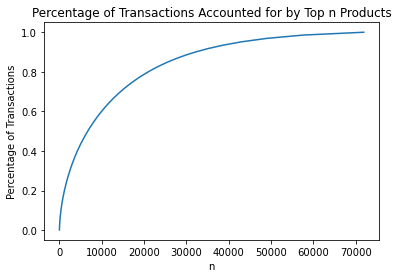

In [5]:
fig, ax = plt.subplots()

plt.plot(range(1, len(transactions_sample.article_id.value_counts()) + 1),
         np.cumsum(transactions_sample.article_id.value_counts(normalize=True)).values)
ax.set(title='Percentage of Transactions Accounted for by Top n Products',
       xlabel = 'n',
       ylabel = 'Percentage of Transactions');

Out of a little over 70,000 unique products in our sample, more than half of transactions involve less than 10,000 of them.

Let's see if we can plot a long tail plot.

In [6]:
# select number of transactions including each article
article_popularity = transactions_sample.article_id.value_counts()

The value counts series above (for the article_id column of transactions_sample) links each article id to the number of times that article was purchased.

| article_id | number of purchases |
| --- | --- |
|  |  |

Below, I reset the index of this series to reference each article by its relative popularity, rather than its unique id.

For example: index 0 refers to the number 1 most popular item, index 1 refers to the second most popular item, etc.

The values in the series still specify how many transactions involved that article. From this series, we can generate our long tail plot.

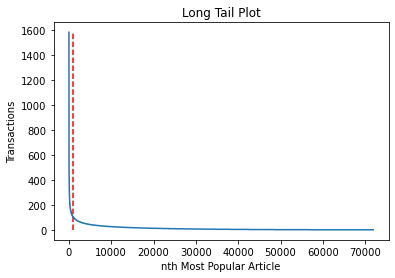

In [7]:
# plot number of transactions versus nth most popular article
fig, ax = plt.subplots()

plt.plot(article_popularity.reset_index().drop(['index'], axis=1))
ax.set(title='Long Tail Plot', xlabel='nth Most Popular Article', ylabel='Transactions')

# highlight the point at which less than 100 transactions include an item
article_no = list(article_popularity.values).index(100)

plt.vlines(x=article_no,
           ymin=0,
           ymax=max(article_popularity.values),
           linestyles='dashed',
           color='r');

Most of our transactions involved articles which were purchased fewer than 100 times. This could be a good thing for training our recommendation system, if most of the items are in the long tail. However, we may want to drop the 1074 most popular items (purchased more than 100 times each) if the system is struggling to provide coverage.

Out of curiosity and practicality, how many items were only purchased once?

---

14,821 items were only purchased once.

1,074 items have been purchased over 100 times.

55,991 items are "in the middle".

This is my first time building a recommendation system, so I want to take a moment to think through how I should structure this project.

- explore metadata on articles & customers
- decide on an evaluation metric
- determine a validation strategy
- decide how to pull the data together: use article_

In [8]:
%%time

with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('articles.csv') as f:
        articles = pd.read_csv(f)

CPU times: user 1.01 s, sys: 41.5 ms, total: 1.05 s
Wall time: 1.05 s


In [33]:
articles.head(2)

article_id  product_code  prod_name  product_type_no product_type_name  \
0   108775015        108775  Strap top              253          Vest top   
1   108775044        108775  Strap top              253          Vest top   

   product_group_name  graphical_appearance_no graphical_appearance_name  \
0  Garment Upper body                  1010016                     Solid   
1  Garment Upper body                  1010016                     Solid   

   colour_group_code colour_group_name  ...  index_code  index_name  \
0                  9             Black  ...           A  Ladieswear   
1                 10             White  ...           A  Ladieswear   

   index_group_no index_group_name  section_no            section_name  \
0               1       Ladieswear          16  Womens Everyday Basics   
1               1       Ladieswear          16  Womens Everyday Basics   

  garment_group_no garment_group_name  \
0             1002       Jersey Basic   
1             1002       Jersey Basic   

                               detail_desc image  
0  Jersey top with narrow shoulder straps.  None  
1  Jersey top with narrow shoulder straps.  None  

[2 rows x 26 columns]

In [34]:
articles.shape

(105542, 26)

In [9]:
%%time

with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('customers.csv') as f:
        customers = pd.read_csv(f)

CPU times: user 4.04 s, sys: 231 ms, total: 4.28 s
Wall time: 4.4 s


In [12]:
customers.head(2)

customer_id  FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3... NaN     NaN   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e... NaN     NaN   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   
1             ACTIVE                   NONE  25.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...

In [45]:
customers.shape

(1371980, 7)

----

I am going to select 800,000 transactions to constitute the training data and 200,000 transactions to make up the hold out test set.

Then, I am going to further subdivide the training data into true training and validation data with a 75% / 25% split.

In [10]:
# get training data (including validation)
train = transactions_sample.sample(800000, random_state=seed).copy()
# which indices are "leftover" after selecting training data?
test_indices = list(set(transactions_sample.index) - set(train.index))
# get test data
test = transactions_sample.loc[ test_indices ].copy()

# get validation data
val = train.sample(200000, random_state=seed).copy()
train_indices = list(set(train.index) - set(val.index))

# reset train to NOT include validation data
train = train.loc[ train_indices ].copy()

In [11]:
print(train.shape)
print(val.shape)
print(test.shape)

(600000, 5)
(200000, 5)
(200000, 5)


## Model 1

Building a recommendation system which uses alternating least squares to obtain a PQ factorization of the utility matrix.

### Build Utility Matrix from Customers & Articles in Training Transaction Data

Recall that the utility matrix refers to the user-item ratings matrix.

In our case, we are using implicit ratings = number of times that a customer has bought an article.

Get the unique customers and articles in the training data.

In [12]:
unique_customers = np.unique(train.customer_id)
unique_articles = np.unique(train.article_id)

Label encode the unique customers and articles so that you can index the utility matrix in base numpy. (Only Pandas lets the index and column names be non-integer or non-consecutive integer.)

In [13]:
from sklearn.preprocessing import LabelEncoder

customer_le = LabelEncoder()
article_le = LabelEncoder()

customer_code = customer_le.fit_transform(unique_customers)
article_code = article_le.fit_transform(unique_articles)

Create a matrix of zeros of the appropriate size for the utility matrix.

In [14]:
utility = np.zeros((len(customer_code), len(article_code)))

Grab transaction information from the training data.

In [15]:
train_transactions = train.loc[:, ['customer_id', 'article_id']].copy()

Label encode the customer and article ids in the training data.

In [16]:
train_transactions['customer_id'] = customer_le.transform(train_transactions['customer_id'])
train_transactions['article_id'] = article_le.transform(train_transactions['article_id'])

Iterate over each row representing a transaction in the training data, and add 1 to the appropriate \[user, item\] entry in the utility matrix.

In [17]:
for i, index in enumerate(train_transactions.index):
    code = train_transactions.loc[index, 'customer_id']
    article = train_transactions.loc[index, 'article_id']
    
    utility[code, article] += 1

*To save space, checking the utility matrix has been deleted.*

### Use Alternating Least Squares to Approximate $PQ^T$ Factorization of Utility Matrix

To get a handle on the process, let's start with $k=5$ latent factors, and build the rank 5 $PQ^{T}$ approximation of the utility / ratings matrix.

The idea behind alternating least squares is to "guess" the values of P and Q, then iteratively update these entries according to least squares.

In [28]:
k = 5

users = np.ones((utility.shape[0], k))
items = np.ones((utility.shape[1], k))

In [ ]:
from sklearn.linear_model import LinearRegression

for row in range(utility.shape[0]):
    lr = LinearRegression(fit_intercept=False)
    # rows of items are "records", target is first row of utility matrix
    lr.fit(items, utility[row,:].reshape(-1, 1))

    users[row, :] = lr.coef_[0]

In [ ]:
users

In [ ]:
for col in range(utility.shape[1]):
    lr = LinearRegression(fit_intercept=False)
    
    lr.fit(users, utility[:, col])
    
    items[:, col] = lr.coef_[0]